In [1]:
pip install websocket-client pillow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#This is an example that uses the websockets api to know when a prompt execution is done
#Once the prompt execution is done it downloads the images using the /history endpoint

import websocket #NOTE: websocket-client (https://github.com/websocket-client/websocket-client)
import uuid
import json
import urllib.request
import urllib.parse
from IPython.display import Image

server_address = "127.0.0.1:8000"
client_id = str(uuid.uuid4())

def queue_prompt(prompt, prompt_id):
    p = {"prompt": prompt, "client_id": client_id, "prompt_id": prompt_id}
    data = json.dumps(p).encode('utf-8')
    req = urllib.request.Request("http://{}/prompt".format(server_address), data=data)
    urllib.request.urlopen(req).read()

def get_image(filename, subfolder, folder_type):
    data = {"filename": filename, "subfolder": subfolder, "type": folder_type}
    url_values = urllib.parse.urlencode(data)
    with urllib.request.urlopen("http://{}/view?{}".format(server_address, url_values)) as response:
        return response.read()

def get_history(prompt_id):
    with urllib.request.urlopen("http://{}/history/{}".format(server_address, prompt_id)) as response:
        return json.loads(response.read())

def get_images(ws, prompt):
    prompt_id = str(uuid.uuid4())
    queue_prompt(prompt, prompt_id)
    output_images = {}
    while True:
        out = ws.recv()
        if isinstance(out, str):
            message = json.loads(out)
            if message['type'] == 'executing':
                data = message['data']
                if data['node'] is None and data['prompt_id'] == prompt_id:
                    break #Execution is done
        else:
            # If you want to be able to decode the binary stream for latent previews, here is how you can do it:
            # bytesIO = BytesIO(out[8:])
            # preview_image = Image.open(bytesIO) # This is your preview in PIL image format, store it in a global
            continue #previews are binary data

    history = get_history(prompt_id)[prompt_id]
    for node_id in history['outputs']:
        node_output = history['outputs'][node_id]
        images_output = []
        if 'images' in node_output:
            for image in node_output['images']:
                image_data = get_image(image['filename'], image['subfolder'], image['type'])
                images_output.append(image_data)
        output_images[node_id] = images_output

    return output_images

prompt_text = """
{
  "60": {
    "inputs": {
      "filename_prefix": "z-image-turbo",
      "images": [
        "83:8",
        0
      ]
    },
    "class_type": "SaveImage",
    "_meta": {
      "title": "Save Image"
    }
  },
  "83:13": {
    "inputs": {
      "width": 1024,
      "height": 1024,
      "batch_size": 1
    },
    "class_type": "EmptySD3LatentImage",
    "_meta": {
      "title": "EmptySD3LatentImage"
    }
  },
  "83:28": {
    "inputs": {
      "unet_name": "z_image_turbo_bf16.safetensors",
      "weight_dtype": "default"
    },
    "class_type": "UNETLoader",
    "_meta": {
      "title": "Load Diffusion Model"
    }
  },
  "83:27": {
    "inputs": {
      "text": "A bear and a lion getting high on marijuana and eating curry",
      "clip": [
        "83:30",
        0
      ]
    },
    "class_type": "CLIPTextEncode",
    "_meta": {
      "title": "CLIP Text Encode (Prompt)"
    }
  },
  "83:33": {
    "inputs": {
      "conditioning": [
        "83:27",
        0
      ]
    },
    "class_type": "ConditioningZeroOut",
    "_meta": {
      "title": "ConditioningZeroOut"
    }
  },
  "83:30": {
    "inputs": {
      "clip_name": "qwen_3_4b.safetensors",
      "type": "lumina2",
      "device": "default"
    },
    "class_type": "CLIPLoader",
    "_meta": {
      "title": "Load CLIP"
    }
  },
  "83:3": {
    "inputs": {
      "seed": 1083768031008833,
      "steps": 4,
      "cfg": 1,
      "sampler_name": "res_multistep",
      "scheduler": "simple",
      "denoise": 1,
      "model": [
        "83:28",
        0
      ],
      "positive": [
        "83:27",
        0
      ],
      "negative": [
        "83:33",
        0
      ],
      "latent_image": [
        "83:13",
        0
      ]
    },
    "class_type": "KSampler",
    "_meta": {
      "title": "KSampler"
    }
  },
  "83:8": {
    "inputs": {
      "samples": [
        "83:3",
        0
      ],
      "vae": [
        "83:29",
        0
      ]
    },
    "class_type": "VAEDecode",
    "_meta": {
      "title": "VAE Decode"
    }
  },
  "83:29": {
    "inputs": {
      "vae_name": "ae.safetensors"
    },
    "class_type": "VAELoader",
    "_meta": {
      "title": "Load VAE"
    }
  }
}
"""

prompt = json.loads(prompt_text)

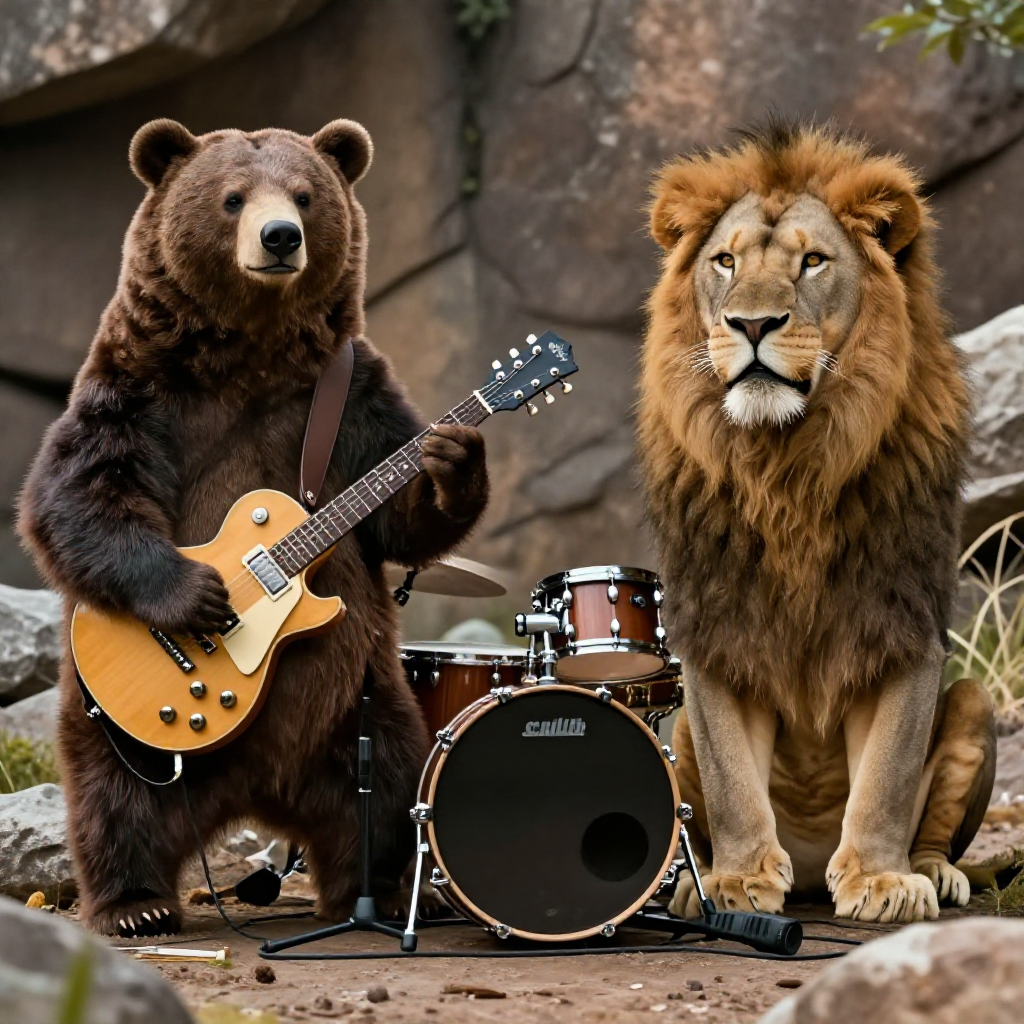

In [3]:
#set the text prompt for our positive CLIPTextEncode
prompt["83:27"]["inputs"]["text"] = "A bear and a lion in a rock band"

# #set the seed for our KSampler node
# prompt["83:3"]["inputs"]["seed"] = 5

ws = websocket.WebSocket()
ws.connect("ws://{}/ws?clientId={}".format(server_address, client_id))
images = get_images(ws, prompt)
ws.close() # for in case this example is used in an environment where it will be repeatedly called, like in a Gradio app. otherwise, you'll randomly receive connection timeouts
#Commented out code to display the output images:

for node_id in images:
    for image_data in images[node_id]:
        display(Image(data=image_data))